This is a quick demonstration of soloving the 1D Gross-Pittaevii equation in a periodic potential

# Solving the 1D Gross-Pittaevskii Equation

We want to minimize
$$
E=\int_0^Ldx \frac{\hbar}{2m} |\partial_x \psi(x)|^2 + V(x)|\psi(x)|^2 + \frac{g N}{2} |\psi(x)|^4.
$$
We first adimensionalize, measuring $x$ in units of $L$, and $E$ in units of $E_0=\hbar^2/(2m L^2)$,
$$
\frac{E}{E_0}=\int_0^1dy  |\partial_y \phi(y)|^2 + \frac{V(y L)}{E_0}|\phi(y)|^2 + \frac{g N}{2 L E_0} |\phi(y)|^4.
$$
Here $y=x/L$ and $\phi=\sqrt{L} \psi$.

The normalization is
$$
\int dx\,|\psi(x)|^2=1,
$$
which is equivalent to
$$
\int dy\,|\phi(y)|^2=1,
$$

We will store $\phi$ as a vector $(\phi_1,\phi_2,\cdots,\phi_n)$ corresponding to the value of the wavefunction at each point.  Similarly we will store the potential $V$ as a vector of points.   If we use trapezoid rule for the integral, and use periodic boundary conditions, we have
$$
\tilde E= \frac{1}{n}\sum_{j=1}^n n^2|\phi_{j+1}-\phi_j|^2 + \tilde V_j |\phi_j|^2+\frac{\eta}{2} |\phi_j|^4 
$$
Here $\tilde V_j= V(jL/n)/E_0$, and $\eta=g N/(L E_0)$.

One tricky thing is how to implement the constraint.  One simple way to do this is just start out our energy function by rescaling
$$
\phi\to\frac{\phi}{\sum_j |\phi_j|^2/n}
$$
This can be thought of as projecting on to the constrained manifold.

We can write this very compactly by using "high-level" syntax.  We construct $\phi$ and $V$ as Vectors.  The conjugate transpose of $\phi$ is $\phi'$.  The function `circshift` circularly permutes the elements of a vector.  The `*` operator is matrix multiplication.

In [2]:
#Import commands to overload
import Base: *,+,-,/,keys,iterate,length,getindex,show,repr,zero
#

struct coovec{T,N} <:AbstractArray{T,N} 
    storage :: Dict{NTuple{N,Int64},T}
end

function coovec(keys::AbstractArray{NTuple{N,Int64}},values::AbstractArray{T,M}) where {T,N,M}
    storage=Dict{NTuple{N,Int64},T}
    for k in eachindex(keys)
        storage[k]=values[k]
    end
end

# Iteration and indexing
Base.iterate(k::coovec)=Base.iterate(k.storage)
Base.iterate(k::coovec,n)=Base.iterate(k.storage,n)
Base.length(k::coovec)=Base.length(k.storage)
Base.keys(k::coovec) = Base.keys(k.storage)

function Base.getindex(k::coovec{T,N},key::NTuple{N,Int64}) where {T,N}
    if key in k.storage
        return Base.getindex(k.storage,val)
    end
    return zero(T)
end

Base.getindex(k::coovec{T,N},coords...)=Base.getindex(k,coords)
Base.getindex(k::coovec{T,N},i::CartesianIndex)=Base.getindex(k,Tuple(i)


function +(k1::coovec,k2::coovec) 
    d=copy(k1.storage)
    for key in keys(k2) 
        if (key in keys(k1))
            d[key]+=k2[key]
        else
            d[key]=k2[key]
        end
        if d[key]===zero(d[key])
            delete!(d,key)
        end
    end
    return ket(d)
end
    

Base.display(c::coovec)=Base.display(c.storage)
Base.show(io::IO,c::coovec)=Base.show(io,c.storage)
Base.show(io::IO,m::MIME{Symbol("text/plain")}, c::coovec)=Base.show(io, m,c.storage)

In [15]:
Tuple(CartesianIndex(1,2,3))

(1, 2, 3)

In [6]:
d1=Dict((1,)=>5.,(2,)=>10.)

Dict{Tuple{Int64}, Float64} with 2 entries:
  (2,) => 10.0
  (1,) => 5.0

In [8]:
for k in keys(c1)

KeySet for a Dict{Tuple{Int64}, Float64} with 2 entries. Keys:
  (2,)
  (1,)

In [4]:
c1=coovec(Dict((1,)=>5.,(2,)=>10.));

In [5]:
c1+c1

LoadError: AbstractDict collections only contain Pairs;
Either look for e.g. A=>B instead, or use the `keys` or `values`
function if you are looking for a key or value respectively.

In [1]:
function energy(phi,V,eta)
    n=length(phi)
    norm=(phi)'*(phi)/n
    ϕ=phi/sqrt(norm)          # scaled wavefunction
    dϕ=n*(circshift(ϕ,1)-ϕ)   # difference between wavefunctions at two sites
    (dϕ'*dϕ+ ϕ'*(V.*ϕ)+(eta/2)*(ϕ.*ϕ)'*(ϕ.*ϕ))/n
end

energy (generic function with 1 method)

It is useful to see how to construct these functions using low-level commands, and compartmentalizing it a bit.  I'll also show you how to debug and validate them.

Note:  If you are working in something like Python or Mathematica, you want to use this sort of high-level syntax.  In Julia or C, the low level works equally well.

In [2]:
#low level, and compartmentalized version of energy
function alten1(phi,V,eta)
    norm=(phi)'*(phi)/length(phi)
    return barekin1(phi)/norm+
            barepot1(phi,V)/norm+
            bareint1(phi,eta)/norm^2
end

alten1 (generic function with 1 method)

In [3]:
function barekin1(phi)
    n=length(phi)
    result=(n*abs(phi[1]-phi[n])^2)
    for i in 1:n-1 #interior points
        result+=n*abs(phi[i+1]-phi[i])^2
    end
    return result
end

barekin1 (generic function with 1 method)

In [4]:
function barepot1(phi,V)
    n=length(phi)
    result=(V[n]*abs(phi[n])^2/n)
    for i in 1:n-1 #interior points
        result+=(V[i]*abs(phi[i])^2/n)
    end
    return result
end

barepot1 (generic function with 1 method)

In [5]:
function bareint1(phi,eta)
    n=length(phi)
    result=(eta/2)*(abs(phi[n])^4/n)
    for i in 1:n-1 #interior points
        result+=(eta/2)*(abs(phi[i])^4/n)
    end
    return result
end

bareint1 (generic function with 1 method)

### Test Energy Functions

First lets take $\phi$ and $V$ to be uniform.  In that case the kinetic energy should vanish, and the only terms are the potential and the interactions

In [6]:
uniformenergy(V,g)=sum(V)/length(V) + g/2

uniformenergy (generic function with 1 method)

In [7]:
uniform10=ones(10)
uniform100=ones(100)
@show energy(uniform10,0*uniform10,0) alten1(uniform10,0*uniform10,0) uniformenergy(0*uniform10,0) 
println()
@show energy(uniform10,uniform10,0) alten1(uniform10,uniform10,0) uniformenergy(uniform10,0) 
println()
@show energy(uniform10,2*uniform10,0) alten1(uniform10,2*uniform10,0) uniformenergy(2*uniform10,0)
println()
@show energy(2*uniform10,0*uniform10,0) alten1(2*uniform10,0*uniform10,0) uniformenergy(0*uniform10,0)
println()
@show energy(2*uniform10,uniform10,0) alten1(2*uniform10,uniform10,0) uniformenergy(uniform10,0)
println()
@show energy(2*uniform10,2*uniform10,0) alten1(2*uniform10,2*uniform10,0)  uniformenergy(2*uniform10,0)
println()
@show energy(2uniform10,3uniform10,5) alten1(2uniform10,3uniform10,5) uniformenergy(3*uniform10,5) 
println()

energy(uniform10, 0uniform10, 0) = 0.0
alten1(uniform10, 0uniform10, 0) = 0.0
uniformenergy(0uniform10, 0) = 0.0

energy(uniform10, uniform10, 0) = 1.0
alten1(uniform10, uniform10, 0) = 0.9999999999999999
uniformenergy(uniform10, 0) = 1.0

energy(uniform10, 2uniform10, 0) = 2.0
alten1(uniform10, 2uniform10, 0) = 1.9999999999999998
uniformenergy(2uniform10, 0) = 2.0

energy(2uniform10, 0uniform10, 0) = 0.0
alten1(2uniform10, 0uniform10, 0) = 0.0
uniformenergy(0uniform10, 0) = 0.0

energy(2uniform10, uniform10, 0) = 1.0
alten1(2uniform10, uniform10, 0) = 0.9999999999999999
uniformenergy(uniform10, 0) = 1.0

energy(2uniform10, 2uniform10, 0) = 2.0
alten1(2uniform10, 2uniform10, 0) = 1.9999999999999998
uniformenergy(2uniform10, 0) = 2.0

energy(2uniform10, 3uniform10, 5) = 5.5
alten1(2uniform10, 3uniform10, 5) = 5.5
uniformenergy(3uniform10, 5) = 5.5



Next we can check the kinetic energy.  If $\phi(x)=\cos(2\pi x)$ then
$$
\int \phi'(x)^2\, dx = (2\pi)^2
$$

In [8]:
cosphi=[cos(2pi*x/10) for x in 1:10]
@show energy(cosphi,0*uniform10,0) alten1(cosphi,0*uniform10,0) (2*pi)^2
println()
cosphi100=[cos(2pi*x/100) for x in 1:100]
@show energy(cosphi100,0*uniform100,0) alten1(cosphi100,0*uniform100,0) (2*pi)^2

energy(cosphi, 0uniform10, 0) = 38.19660112501052
alten1(cosphi, 0uniform10, 0) = 38.19660112501051
(2pi) ^ 2 = 39.47841760435743

energy(cosphi100, 0uniform100, 0) = 39.465431434568764
alten1(cosphi100, 0uniform100, 0) = 39.46543143456875
(2pi) ^ 2 = 39.47841760435743


39.47841760435743

Seems reasonable

Finally lets compare the timing of our two methods

In [9]:
randphi=randn(100000)
randV=randn(100000);

In [10]:
@time energy(randphi,randV,0.5)

  0.041286 seconds (18.21 k allocations: 6.467 MiB, 98.04% compilation time)


1.998297831604465e10

In [11]:
@time alten1(randphi,randV,0.5)

  0.013862 seconds (7.83 k allocations: 516.641 KiB, 95.01% compilation time)


1.9982978316044674e10

Looks like the low-level code is about 20\% faster.  This is not enough of a speed difference that I would worry about it.  **Caution:** If you wrote this code in Python, the low-level code would be much slower.  As much as possible use high-level constructions in Python.

## Gradients

If we are going to minimize this function, it is also useful to have the gradient.  We will use a trick from complex analysis, and treat $\phi$ and $\phi^*$ as independent

\begin{align}
\tilde E&= \frac{1}{n}\sum_{j=1}^n n^2|\phi_{j+1}-\phi_j|^2 + \tilde V_j |\phi_j|^2+\frac{\eta}{2} |\phi_j|^4 \\
&= \frac{1}{n}\sum_{j=1}^n n^2 \phi_j^* (2\phi_j-\phi_{j+1}-\phi_{j-1}) + \tilde V_j |\phi_j|^2+\frac{\eta}{2} |\phi_j|^4
\end{align}
The deriviative is then
\begin{align}
\frac{\partial \tilde E}{\partial \phi_j^*}&= n(\phi_{j}^2-\phi_{j+1}-\phi_{j-1})+V_j \phi_j + \eta |\phi_j|^2\phi_j.
\end{align}
If we had not rescaled $\phi$ we woud be done.  Lets write $\phi_j=\varphi_j/\sqrt{N}$, and then
\begin{align}
\frac{\partial \tilde E}{\partial \varphi_j^*}
&= \frac{\partial \tilde E}{\partial \phi_j^*}\frac{1}{\sqrt{N}}-(K+V+2U)\frac{\phi_j}{N}
\end{align}
where we have used that
$$
\frac{\partial N}{\partial \varphi_j^*}=\frac{1}{n*N}\phi_j
$$
In our high-level language this can be written as

In [12]:
function denergy_dphistar(phi,V,eta)
    n=length(phi)
    norm=(phi)'*(phi)/n
    ϕ=phi/sqrt(norm)
    dϕ=n*(circshift(ϕ,1)-ϕ)
    ddϕ=n*(circshift(dϕ,-1)-dϕ)
    (ddϕ+ (V.*ϕ)+(eta)*(conj(ϕ).*ϕ.*ϕ))/(n*sqrt(norm))- #derivative wrt ϕ'
        (phi/norm)*(dϕ'*dϕ+ ϕ'*(V.*ϕ)+(eta)*(ϕ.*ϕ)'*(ϕ.*ϕ))/n^2 # derivative of norm
end

# for reference, the energy function was
#
#  function energy(phi,V,eta)
#    n=length(phi)
#    norm=(phi)'*(phi)/n
#    ϕ=phi/sqrt(norm)          # scaled wavefunction
#    dϕ=n*(circshift(ϕ,1)-ϕ)   # difference between wavefunctions at two sites
#    (dϕ'*dϕ+ ϕ'*(V.*ϕ)+(eta/2)*(ϕ.*ϕ)'*(ϕ.*ϕ))/n
#  end

denergy_dphistar (generic function with 1 method)

If $\phi$ is real then we can then construct the gradient

In [13]:
function gradenergy(phi,V,eta)
    de=denergy_dphistar(phi,V,eta)
    return de + conj(de)
end

gradenergy (generic function with 1 method)

Now lets do the same thing using our low-level code

In [21]:
function dalten_dphistar1(phi,V,eta)
    norm=(phi)'*(phi)/length(phi)
    dnorm_dphistar=(phi)/length(phi)
    #
    # Lets first calculate the contribution from d Norm / d phi^*
    #
    coef= -barekin1(phi)/norm^2-# derivative of kinetic wrt norm
        barepot1(phi,V)/norm^2- # derivative of potential wrt norm
        2*bareint1(phi,eta)/norm^3 # derivative of int wrt norm
    result=coef*dnorm_dphistar
    #
    # Now the derivitives of each of the bare quantities
    #
    add_dbarekin_dphistar1!(result,phi,1/norm)
    add_dbarepot_dphistar1!(result,phi,V,1/norm)
    add_dbareint_dphistar1!(result,phi,eta,1/norm^2)
    return result
end

# For comparison, here was the energy code
#
#function alten1(phi,V,eta)
#    norm=(phi)'*(phi)/length(phi)
#    return barekin1(phi)/norm+
#            barepot1(phi,V)/norm+
#            bareint1(phi,eta)/norm^2
#end

dalten_dphistar1 (generic function with 1 method)

In [22]:
function add_dbarekin_dphistar1!(result,phi,scale)
    n=length(phi)
    result[n]+=(2*n*phi[n]-n*phi[1])*scale
    result[1]+=-n*phi[n]*scale
    for i in 1:n-1 #interior points
        result[i]+=2*n*phi[i]*scale
        result[i]+=-n*phi[i+1]*scale
        result[i+1]+=-n*phi[i]*scale
    end
    return result
end

add_dbarekin_dphistar1! (generic function with 1 method)

In [16]:
function add_dbarepot_dphistar1!(result,phi,V,scale)
    n=length(phi)
    for i in eachindex(result)
        result[i]+=V[i]*phi[n]*scale/n 
    end
    return result
end

add_dbarepot_dphistar1! (generic function with 1 method)

In [17]:
function add_dbareint_dphistar1!(result,phi,eta,scale)
    n=length(phi)
    for i in eachindex(result)
        result[i]+=eta*abs(phi[i])^2*phi[i]*scale/n 
    end
    return result
end

add_dbareint_dphistar1! (generic function with 1 method)

## testing

In [30]:
cosphi=[1+cos(2pi*x/10) for x in 1:10000]
zero1000=zeros(10000);

In [46]:
@time denergy_dphistar(cosphi,0.2*cosphi,0.5)[1:10]

  0.000170 seconds (41 allocations: 1.527 MiB)


10-element Vector{Float64}:
   524.5955232949746
  -324.21789401921967
 -1373.4089103322112
 -2222.2222382036825
 -2546.4400750006953
 -2222.2222382036825
 -1373.4089103322121
  -324.2178940192216
   524.5955232949764
   848.8134153706185

In [47]:
@time dalten_dphistar1(cosphi,0.2*cosphi,0.5)[1:10]

  0.000117 seconds (7 allocations: 234.656 KiB)


10-element Vector{Float64}:
   524.5955279015311
  -324.21788195909915
 -1373.4088982720975
 -2222.2222335971283
 -2546.440075000696
 -2222.2222335971283
 -1373.4088982720968
  -324.2178819591037
   524.5955279015348
   848.8134153706233

We get a factor of 2 speedup from the item-by-item version

## Automatic differentiation

In [51]:
using ForwardDiff

In [53]:
@time ForwardDiff.gradient(phi->energy(phi,0.2*cosphi,0.5), cosphi)[1:10]

  1.475046 seconds (1.23 M allocations: 5.799 GiB, 17.97% gc time, 20.00% compilation time)


10-element Vector{Float64}:
  1049.1910465899118
  -648.4357880384739
 -2746.8178206640982
 -4444.4444764092095
 -5092.88015000151
 -4444.444476409208
 -2746.8178206641014
  -648.4357880384772
  1049.1910465899155
  1697.6268307406049

That is too slow.  Write my own forward AD algorithm.  

I'll also make my own COO sparse matrix code. 

Also change structure of energy, so it is explicitly called with phi and phistar.

In [74]:
struct dual
    x
    dx
end

Base.:+(a::dual,b::dual)=dual(a.x+b.x,a.dx+b.dx)
Base.:+(a::dual,b)=dual(a.x+b,a.dx)
Base.:+(b,a::dual)=dual(b+a.x,a.dx)

Base.:*(a::dual,b::dual)=dual(a.x*b.x,a.x*b.dx+a.dx*b.x)
Base.:*(a::dual,b)=dual(a.x*b,a.dx*b)
Base.:*(b,a::dual)=dual(b*a.x,b*a.dx)

Base.:^(a::dual,b)=dual(a.x^b,a.dx*a.x^(b-1)*b)

In [80]:
using SparseArrays

In [92]:
onehot(pos,len)=sparsevec([pos],[1.],len)

onehot (generic function with 1 method)

In [93]:
onehot(5,10)

10-element SparseVector{Float64, Int64} with 1 stored entry:
  [5]  =  1.0

In [89]:
s1=sparsevec([5],[1],10)

10-element SparseVector{Int64, Int64} with 1 stored entry:
  [5]  =  1

In [95]:
s1'

1×10 adjoint(::SparseVector{Int64, Int64}) with eltype Int64:
 0  0  0  0  1  0  0  0  0  0

In [105]:
I = [1, 4, 3, 5]; J = [4, 7, 18, 9]; V = [1, 2, -5, 3];

In [106]:
S = sparse(I,J,V)

5×18 SparseMatrixCSC{Int64, Int64} with 4 stored entries:
⎡⠀⠈⠀⠀⠀⠀⠀⠀⢀⎤
⎣⠀⠀⠀⠂⡀⠀⠀⠀⠀⎦

In [107]:
R = sparsevec(I,V)

5-element SparseVector{Int64, Int64} with 4 stored entries:
  [1]  =  1
  [3]  =  -5
  [4]  =  2
  [5]  =  3

In [110]:
S'*R

18-element SparseVector{Int64, Int64} with 4 stored entries:
  [4 ]  =  1
  [7 ]  =  4
  [9 ]  =  9
  [18]  =  25

In [111]:
S'*[1,2,3,4,5]

18-element Vector{Int64}:
   0
   0
   0
   1
   0
   0
   8
   0
  15
   0
   0
   0
   0
   0
   0
   0
   0
 -15

In [104]:
mu=s1*[1, 2, 3, 4, 5]

LoadError: MethodError: no method matching *(::SparseVector{Int64, Int64}, ::Vector{Int64})

[0mClosest candidates are:
[0m  *(::Any, ::Any, [91m::Any[39m, [91m::Any...[39m)
[0m[90m   @[39m [90mBase[39m [90m[4moperators.jl:587[24m[39m
[0m  *([91m::dual[39m, ::Any)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[74]:11[24m[39m
[0m  *(::Any, [91m::dual[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[74]:12[24m[39m
[0m  ...


In [102]:
typeof(mu)

Matrix{Int64} (alias for Array{Int64, 2})

In [87]:
s1.*[1,2,3,4,5]

5-element SparseVector{Int64, Int64} with 1 stored entry:
  [5]  =  5

In [ ]:
onehot(val,length)=sparse([val],[1]

In [ ]:
vecdual(vec)
    [dual(vec,

In [64]:
dual(2,1)+dual(2,2)

dual(4, 3)

In [65]:
dual(2,1)+3

dual(5, 1)

In [78]:
(x->2*x^2+5+3*x^4)(dual(5,1))

dual(1930, 1520)

## old

In [182]:
@time (energy(5*phi1+0.0001*dphi1,V1,0.)-energy(5*phi1-0.0001*dphi1,V1,0.))/(2*0.0001)

  0.000030 seconds (24 allocations: 17.562 KiB)


-17.253210471608327

In [183]:
@time 2*denergy_dphistar(5*phi1,V1,0.)

  0.000015 seconds (21 allocations: 18.375 KiB)


100-element Vector{Float64}:
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
   ⋮
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665
 -17.25321046956181
  14.116263111459665

In [179]:
@time ForwardDiff.gradient(phi->energy(phi,V1,0.2), 2*phi1)

  0.274830 seconds (1.17 M allocations: 80.538 MiB, 6.85% gc time, 99.88% compilation time)


100-element Vector{Float64}:
 -43.13344896297312
  35.291003696977846
 -43.13344896297312
  35.291003696977846
 -43.133448962973105
  35.291003696977846
 -43.133448962973105
  35.291003696977846
 -43.133448962973105
  35.291003696977846
 -43.1334489629731
  35.29100369697785
 -43.1334489629731
   ⋮
 -43.13344896297298
  35.29100369697788
 -43.13344896297298
  35.29100369697788
 -43.13344896297298
  35.29100369697788
 -43.13344896297297
  35.29100369697788
 -43.13344896297296
  35.29100369697788
 -43.13344896297296
  35.291003696977846

In [88]:
phi0=[1. for j in 1:100]
phi1=[0.1*(-1)^j+1 for j in 1:100]
V1=[0. for j in 1:100];

In [89]:
using Plots

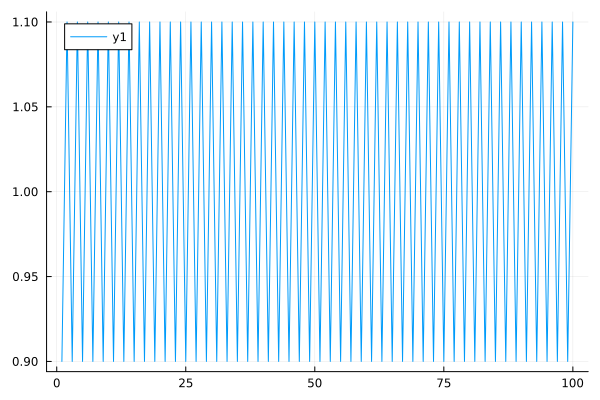

In [90]:
plot(phi1)

In [91]:
energy(phi0,V1,0.1)

0.05

In [92]:
energy(phi1,V1,0.)

396.03960396039616

In [52]:
using Zygote

In [53]:
gradient(x -> 3x^2 + 2x + 1, 5)

(32.0,)

In [93]:
gradient(phi->energy(phi,V1,0.2),phi0)

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0],)

In [94]:
gradient(phi->energy(phi,V1,0.2),phi1)

([-86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575  …  -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575],)

In [95]:
dphi1=zeros(length(phi1));
dphi1[1]=1

1

In [103]:
@time (energy(phi1+0.001*dphi1,V1,0.2)-energy(phi1-0.001*dphi1,V1,0.2))/(2*0.001)

  0.000024 seconds (22 allocations: 15.812 KiB)


-86.26690055490371

In [109]:
@time (energy(phi1+0.001*dphi1,V1,0.2)-energy(phi1-0.001*dphi1,V1,0.2))/(2*0.001)

  0.000021 seconds (22 allocations: 15.812 KiB)


-80.0008455747161

In [99]:
@time gradient(phi->energy(phi,V1,0.2),phi1)

  0.040099 seconds (120.92 k allocations: 6.862 MiB, 99.46% compilation time)


([-86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575  …  -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575, -86.26689792594591, 70.58200739395575],)

In [76]:
using ForwardDiff

In [100]:
@time ForwardDiff.gradient(phi->energy(phi,V1,0.2), phi1)

  0.257379 seconds (1.15 M allocations: 78.665 MiB, 4.03% gc time, 99.88% compilation time)


100-element Vector{Float64}:
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
   ⋮
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578
 -86.26689792594597
  70.58200739395578

In [83]:
using ReverseDiff

In [102]:
@time ReverseDiff.gradient(phi->energy(phi,V1,0.2), phi1)

  0.013551 seconds (10.63 k allocations: 760.852 KiB, 98.76% compilation time)


100-element Vector{Float64}:
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
   ⋮
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573
 -86.2668979259459
  70.58200739395573